In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from collections import Counter, defaultdict
import os
import glob
import json
import re
import sys

import inflect
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from java_api import ClassPaths

In [3]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def is_number_but_not_int(s):
    if s[0] == '-':
        return is_number(s) and not s[1:].isdigit()
    
    return is_number(s) and not s.isdigit()

In [4]:
game_files = glob.glob(os.path.join("../ludii_data/games/expanded", "**", "*.lud"), recursive=True)

contains_track = []
numbers = []
non_float_numbers = []
game_texts = []

for game_file in game_files:
    game_text = open(game_file, "r").read()
    game_texts.append(game_text)

In [5]:
prefix_mapping = defaultdict(set)

for game in game_texts:
    quote_sections = re.finditer(r'\"(.+?)\"', game)

    for match in quote_sections:
        start_idx = match.start()
        paren_start = game.rfind("(", 0, start_idx)

        prefix = game[paren_start+1:start_idx].strip()
        quoted = match.group(0)

        prefix_mapping[prefix].add(quoted)

print(game_texts[0])

(game "Gabata (Wuqro)" (players 2) (equipment {(mancalaBoard 2 6 store:None (track "Track" "0,E,N,W" loop:True)) (piece "Seed" Shared) (hand Each) (regions P1 (sites Bottom)) (regions P2 (sites Top)) (map "LeftMost" {(pair P1 0) (pair P2 11)})}) (rules (start {(set RememberValue "OwnedP1" (sites Bottom)) (set RememberValue "OwnedP2" (sites Top)) (set Count 3 to:(sites Track))}) phases:{(phase "Opening" (play (if (is Prev Mover) (move Select (from (var "Replay")) (then (sow apply:(if (< 1 (count at:(to))) (and (moveAgain) (set Var "Replay" (to))) (set Var "Round" (+ 1 (var "Round"))))))) (move (from 0) (to 11) count:(count at:(to)) (then (and {(forEach Site (sites Mover) (if (is Occupied (site)) (fromTo (from (site)) (to 11) count:(count at:(site))))) (moveAgain) (set Var "Replay" 11)}))))) (nextPhase (not (is Next Mover)) "Sowing")) (phase "Sowing" (play (or {(move Select (from (if (is Prev Mover) (sites {(var "Replay")}) (if (is Mover P1) (sites (values Remembered "OwnedP1")) (sites (

In [6]:
len(contains_track), len(game_files)

(0, 1212)

In [7]:
GREEK_ALPHABET = ["alpha", "beta", "gamma", "delta", "epsilon", "zeta", "eta", "theta", "iota", "kappa", "lambda", "mu",
                  "nu", "xi", "omicron", "pi", "rho", "sigma", "tau", "upsilon", "phi", "chi", "psi", "omega"]

def _mask_names(game: str):
    '''
    Masks out the names of the game and pieces, replacing them with generic identifiers
    '''

    engine = inflect.engine()
    
    # Mask the game's overall name
    game = re.sub(r"(?<=\(game\s\").*?(?=\")", "GAME_NAME", game)

    # NOTE: it's possible that a string immediately following '(piece' could be a macro / define, at least
    # in principle, but it's unlikely in practice. Still something to keep an eye on

    # Extract all pieces that begin with '(piece', and ignore any trailing numbers
    pieces = re.findall(r"(?<=\(piece\s\").*?(?=[0-9]*\")", game)

    # Dedupe pieces, but keep order
    pieces = list(dict.fromkeys(pieces))

    for idx, piece in enumerate(pieces):
        if idx >= len(GREEK_ALPHABET):
            suffix = engine.number_to_words(idx // len(GREEK_ALPHABET) + 1).upper().replace("-", "_")
            new_name = GREEK_ALPHABET[idx % len(GREEK_ALPHABET)].upper() + "_" + suffix
        else:
            new_name = GREEK_ALPHABET[idx].upper()

        # Exact matches for the piece name
        expr = re.compile(r"(?<=\"){0}(?=\")".format(piece))
        game = re.sub(expr, f"PIECE_{new_name}", game)

        # Matches for the piece name followed by a (player) number
        expr = re.compile(r"{0}(?=[0-9])".format(piece))
        game = re.sub(expr, f"PIECE_{new_name}", game)

    return game

In [8]:
def get_game_tokens(game):
    # Mask game and piece names
    game = _mask_names(game)

    # Remove parentheses and curly braces
    game = re.sub(r"[\(\)\{\}]", "", game)

    tokens = game.split()

    # Remove all numbers
    tokens = [token for token in tokens if not is_number(token)]

    return tokens

Java command: java -cp ../ludii_fork/Generation/bin:../ludii_fork/Common/bin:../ludii_fork/Common/lib/json-20180813.jar:../ludii_fork/Common/lib/Trove4j_ApacheCommonsRNG.jar:../ludii_fork/Core/bin:../ludii_fork/Core/lib/jfreesvg-3.4.jar:../ludii_fork/Language/bin:../ludii_fork/Evaluation/bin:../ludii_fork/AI/bin:../ludii_fork/Player/bin:../ludii_fork/Recommender/bin:../ludii_fork/Manager/bin:../ludii_fork/ViewController/bin:../ludii_fork/Mining/bin approaches.symbolic.api.ClassPathEndpoint
Started java classpath process...



# Raw Tokenization

In [10]:
token_counts_by_game = [get_game_tokens(game) for game in tqdm(game_texts, desc='Counting tokens')]
all_token_counts = Counter(sum(token_counts_by_game, []))
print(all_token_counts)

Counting tokens:   0%|          | 0/1212 [00:00<?, ?it/s]

Counting tokens: 100%|██████████| 1212/1212 [00:00<00:00, 1906.44it/s]


Counter({'to': 14382, 'sites': 13782, 'is': 11919, 'if': 11636, 'Mover': 9625, 'from': 6768, 'move': 5961, 'count': 5879, '=': 5311, 'who': 5178, 'To': 5147, 'at:to': 4859, 'P1': 4767, 'Empty': 4181, 'and': 4147, 'last': 3823, 'if:is': 3709, 'place': 3674, 'P2': 3621, 'set': 3421, 'piece': 3416, 'then': 3283, 'id': 3274, 'In': 3131, 'between': 3064, 'mapEntry': 2822, 'Enemy': 2818, 'remove': 2759, '"PIECE_ALPHA"': 2738, 'forEach': 2664, 'apply': 2634, 'Move': 2562, 'not': 2360, 'site': 2357, 'or': 2282, 'Occupied': 2238, 'Next': 2219, 'pair': 2130, 'Each': 2016, '+': 1851, 'handSite': 1851, 'Sites': 1825, 'regions': 1742, 'what': 1739, 'play': 1678, 'Piece': 1677, 'at:site': 1664, 'at:last': 1590, 'Orthogonal': 1564, 'moveAgain': 1552, 'result': 1537, 'var': 1536, 'trackSite': 1497, 'Stack': 1352, '-': 1339, 'if:and': 1324, '"PIECE_BETA"': 1308, 'From': 1280, 'Step': 1257, 'F': 1236, 'players': 1219, '!=': 1215, 'end': 1214, 'game': 1212, '"GAME_NAME"': 1212, 'equipment': 1212, 'rules'

Text(0.5, 1.0, 'Token counts (log scale)')

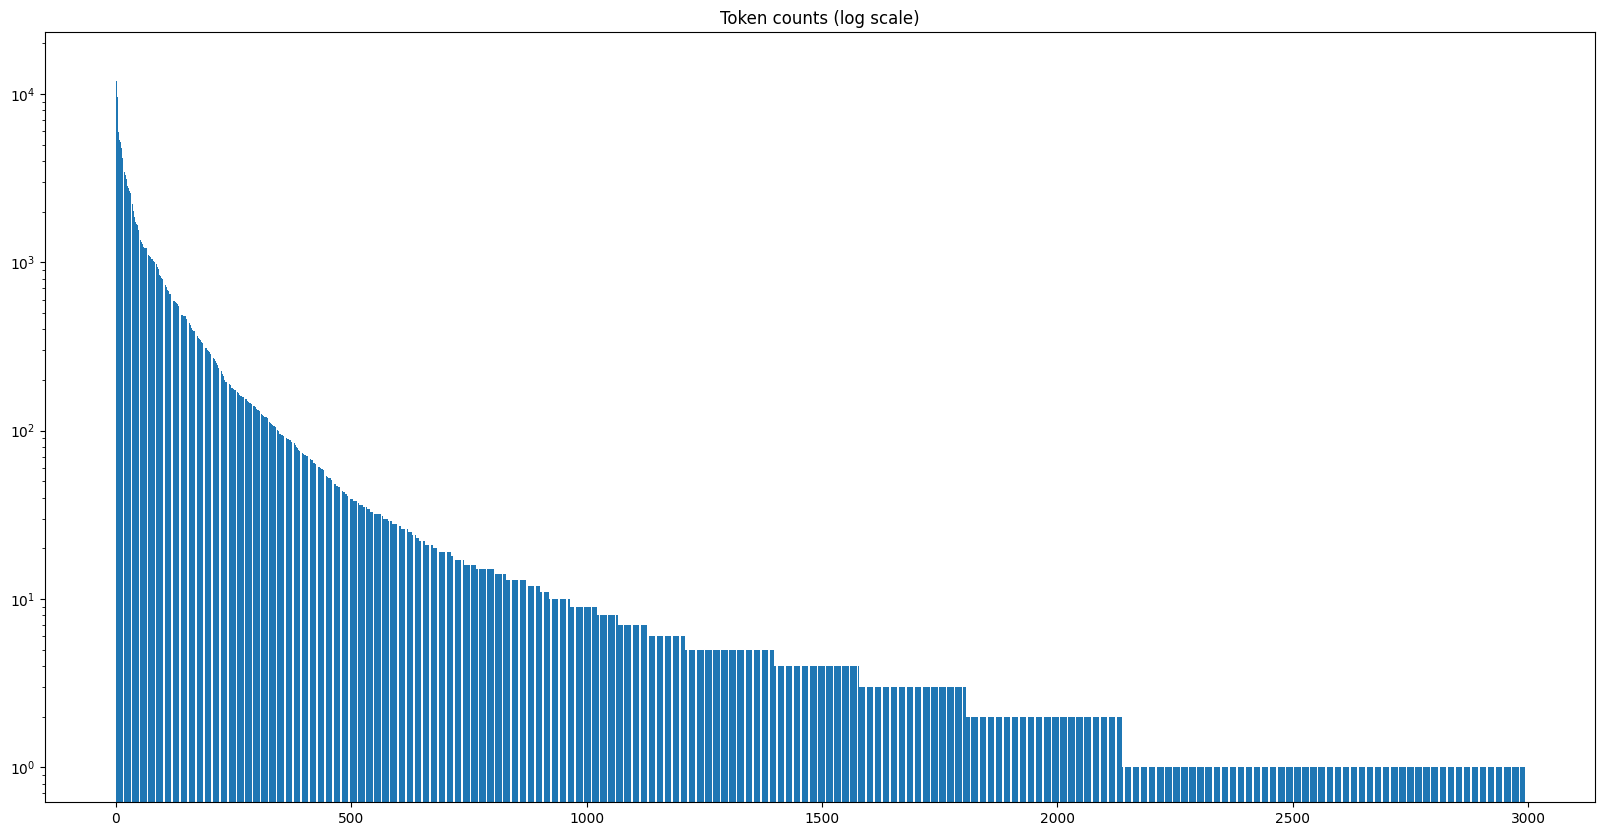

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(range(len(all_token_counts)), sorted(all_token_counts.values(), reverse=True))
ax.set_yscale('log')
plt.title("Token counts (log scale)")

Text(0.5, 1.0, 'Number of game appearances per token (log scale)')

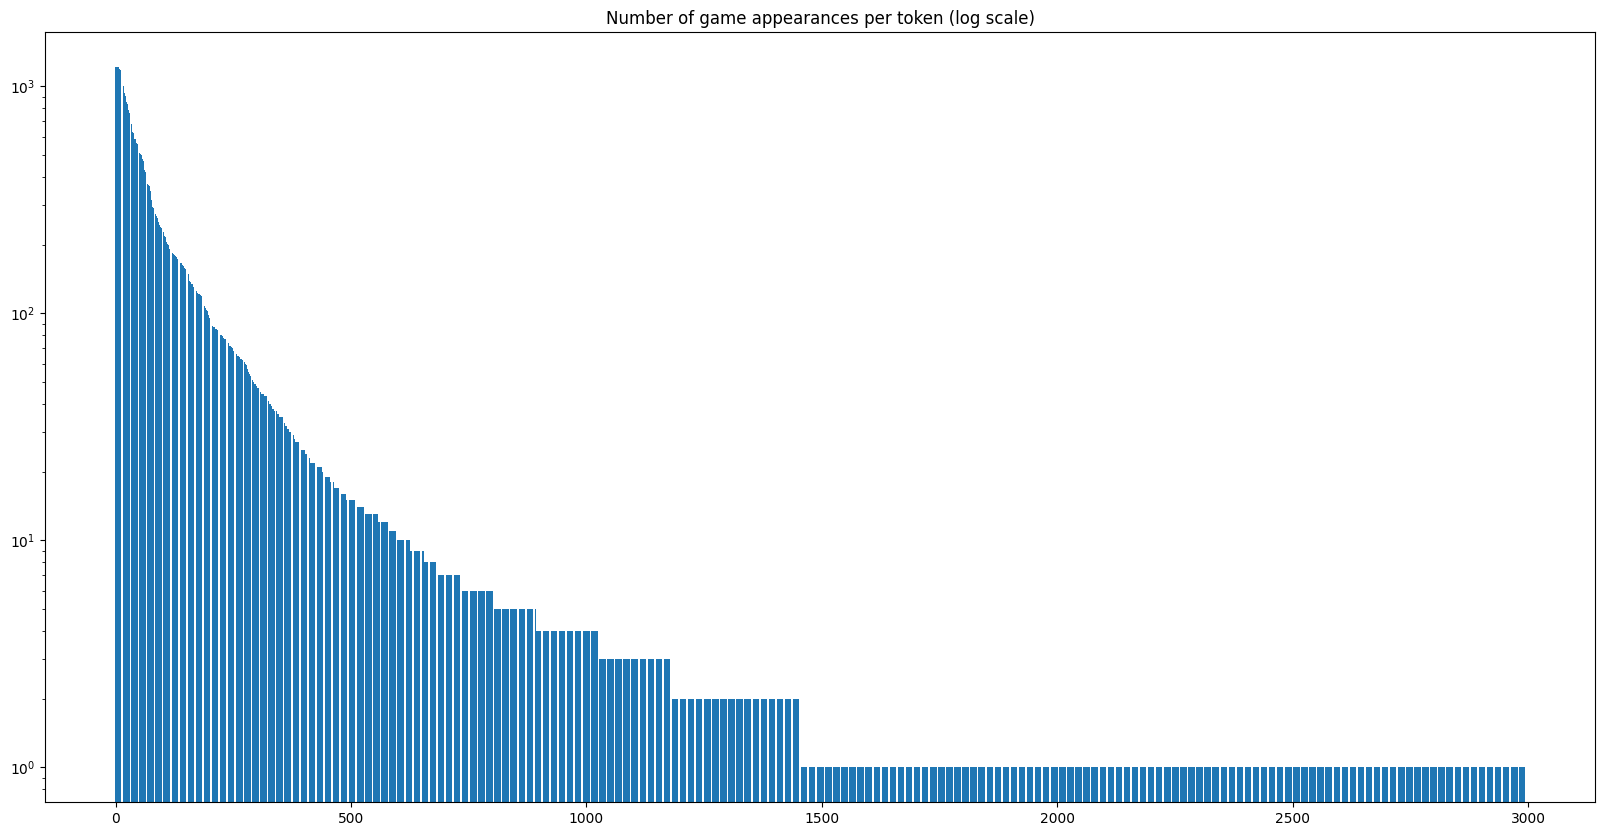

In [11]:
# The number of games in which each token appears at least once
token_game_occurrences = Counter(sum([list(set(counts)) for counts in token_counts_by_game], []))

fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(range(len(token_game_occurrences)), sorted(token_game_occurrences.values(), reverse=True))
ax.set_yscale('log')
plt.title("Number of game appearances per token (log scale)")

In [12]:
token_game_occurrences["game"]

1212

In [13]:
def get_rarest_tokens(game: str, count: int):
    '''
    Return the `count` tokens that appear in the fewest games
    '''

    tokens = set(get_game_tokens(game))
    game_occurrences = [(token, token_game_occurrences[token]) for token in tokens]

    # Convert to new counter object
    game_occurrences = Counter(dict(game_occurrences))

    # Return the `count` least common tokens
    return game_occurrences.most_common()[:-count-1:-1]
    

In [14]:
print(get_rarest_tokens(game_texts[500], 20))
print(game_texts[500])

[('Line', 158), ('Add', 177), ('"PIECE_BETA"', 368), ('square', 465), ('Win', 760), ('P2', 836), ('P1', 855), ('Empty', 906), ('board', 1006), ('is', 1007), ('Mover', 1036), ('result', 1056), ('sites', 1156), ('"PIECE_ALPHA"', 1168), ('to', 1175), ('piece', 1179), ('move', 1188), ('if', 1208), ('end', 1212), ('equipment', 1212)]
(game "Tic-Tac-Toe" (players 2) (equipment {(board (square 3)) (piece "Disc" P1) (piece "Cross" P2)}) (rules (play (move Add (to (sites Empty)))) (end (if (is Line 3) (result Mover Win))))) 


In [15]:
thresholds = np.arange(0.01, 1.01, 0.01)
counts = []

for threshold in tqdm(thresholds, desc='Computing for all thresholds'):

    num_tokens_threshold = int(len(token_game_occurrences) * threshold)
    least_common_tokens = set([token for token, _ in token_game_occurrences.most_common()[-num_tokens_threshold:]])

    # The number of games that contain a token among the least common threshold% of tokens
    n_games = len([game for game in game_texts if len(set(get_game_tokens(game)).intersection(least_common_tokens)) > 0])
    counts.append(n_games)

Computing for all thresholds: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Text(0, 0.5, 'Number of games containing only tokens above threshold')

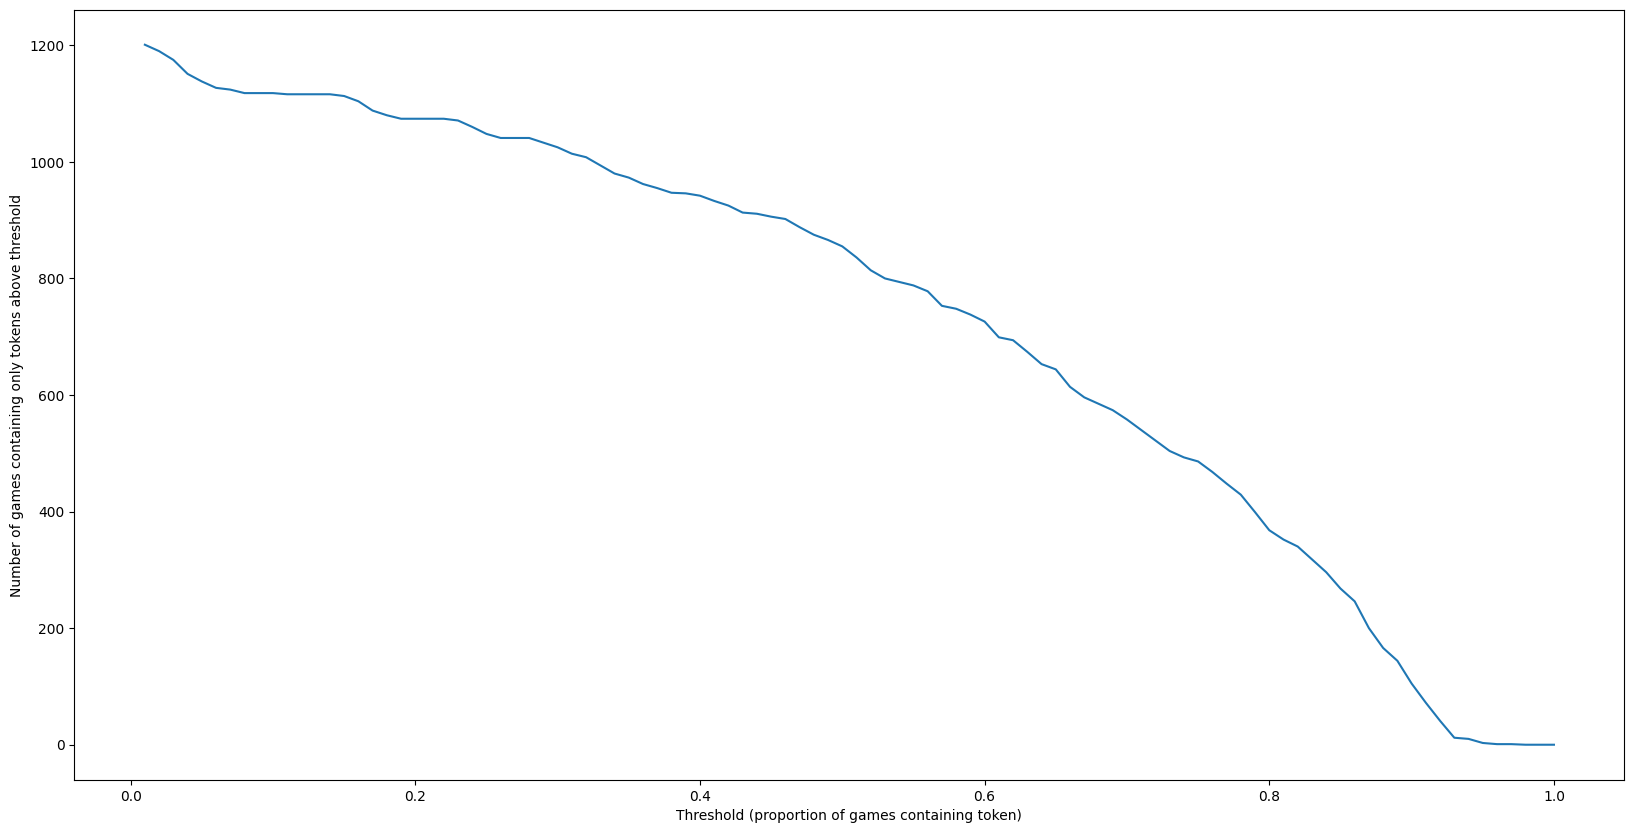

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(thresholds, [len(game_texts) - count for count in counts])
ax.set_xlabel("Threshold (proportion of games containing token)")
ax.set_ylabel("Number of games containing only tokens above threshold")

In [18]:
THRESHOLD = 0.8

c = 0
for file, game in zip(game_files, game_texts):
    num_tokens_threshold = int(len(token_game_occurrences) * THRESHOLD)
    least_common_tokens = set([token for token, _ in token_game_occurrences.most_common()[-num_tokens_threshold:]])

    if len(set(get_game_tokens(game)).intersection(least_common_tokens)) == 0:
        game_name = file.split("/")[-1].split(".")[0]
        print(f"[{c}] {game_name}")
        c += 1

[0] Gabata (Ghinda)
[1] Um el-Bil
[2] Adidada
[3] Wari
[4] Wore
[5] Ntyenge
[6] Hoyito
[7] French Wari
[8] Khrour
[9] Mankala
[10] Leyla Gobale (Somaliland)
[11] Mangala (Turkey)
[12] Andada
[13] Pachgarhwa
[14] I
[15] Motiq
[16] Whyo
[17] Kapana Bona
[18] Tap Urdy
[19] Das Bohnenspiel
[20] Hufesay
[21] Awari
[22] Oure Ngat
[23] Tuz
[24] Gamacha (Nobility)
[25] Boukerourou
[26] Meusueb
[27] Leyla
[28] En Gehe
[29] Kpo
[30] Altiev
[31] Shono
[32] Aw-li On-nam Ot-tjin
[33] Gabata (Adegrat)
[34] Mangala (Suez)
[35] Halusa
[36] Uril
[37] Vai Lung Thlan
[38] Lisolo
[39] Mwambulula
[40] Tsoro (Reentered Captures)
[41] Njombwa
[42] Bao Ki Arabu (Zanzibar 2)
[43] Sute
[44] Kisolo (Lali)
[45] Nsumbi
[46] Njombwa (Two Counters)
[47] Tsoro (Additional Capture)
[48] Tsoro
[49] Sat Gol
[50] Pic
[51] Aralzaa
[52] Lelac
[53] O-Pat-Kono
[54] Bajr
[55] Dodgem
[56] Imperial
[57] Pareia de Entrada
[58] Ludus Lombardorum
[59] Uturu Uturu Kaida
[60] Paumecary
[61] Cab e Quinal
[62] Ludus Anglicorum
[63] My

# Class-path Tokenization

In [13]:
class_path_data = json.load(open("../caches/class_paths.json", "r"))

all_token_counts = Counter(sum([entry["class_paths"] for entry in class_path_data], []))

Text(0.5, 1.0, 'Class-path token counts (log scale)')

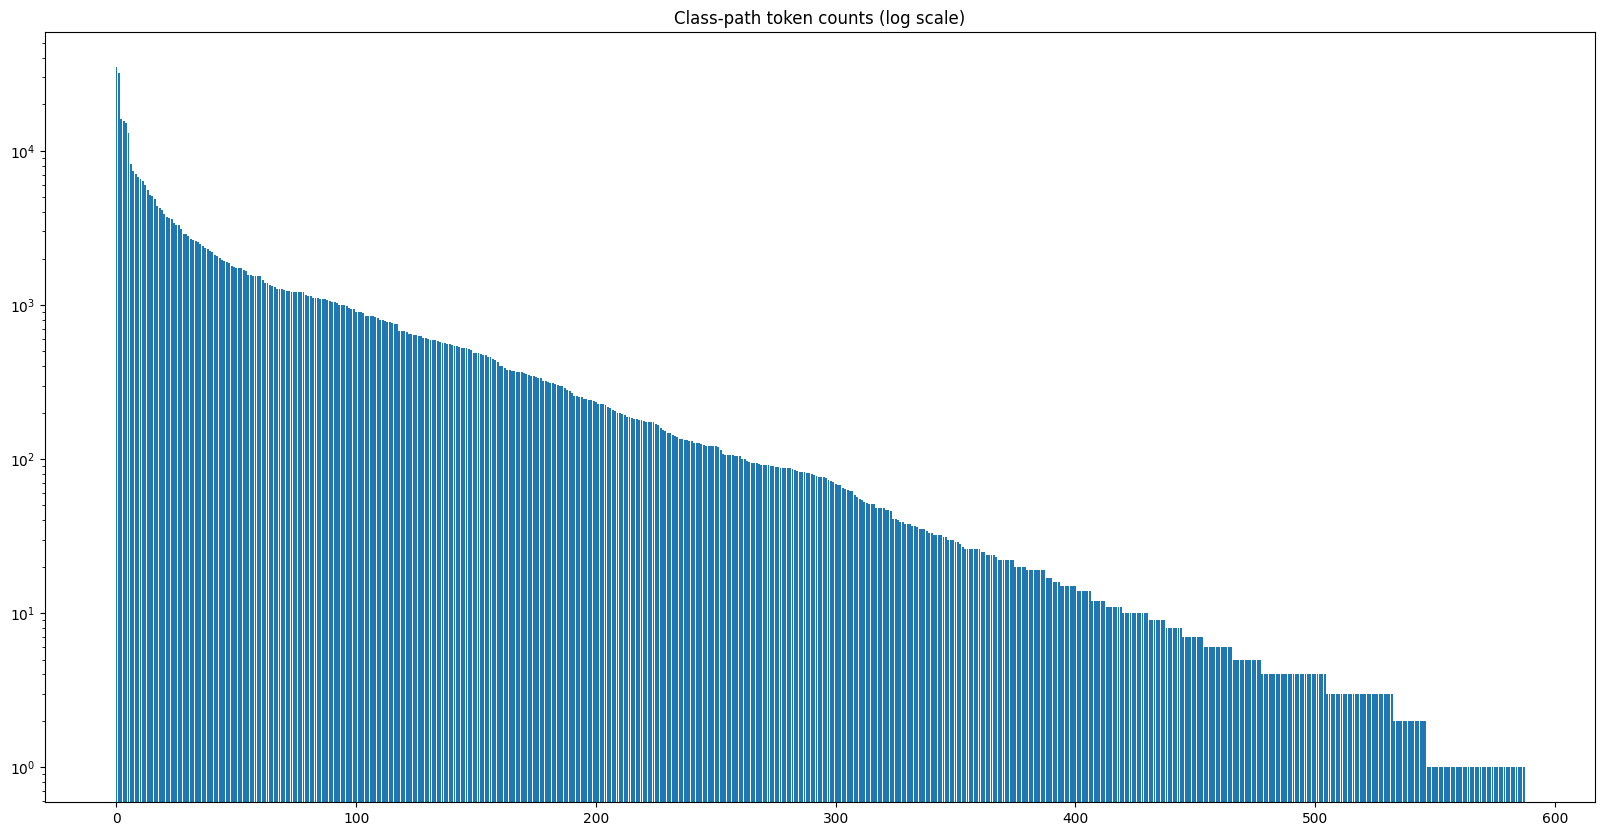

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(range(len(all_token_counts)), sorted(all_token_counts.values(), reverse=True))
ax.set_yscale('log')
plt.title("Class-path token counts (log scale)")

Text(0.5, 1.0, 'Number of game appearances per class-path token (log scale)')

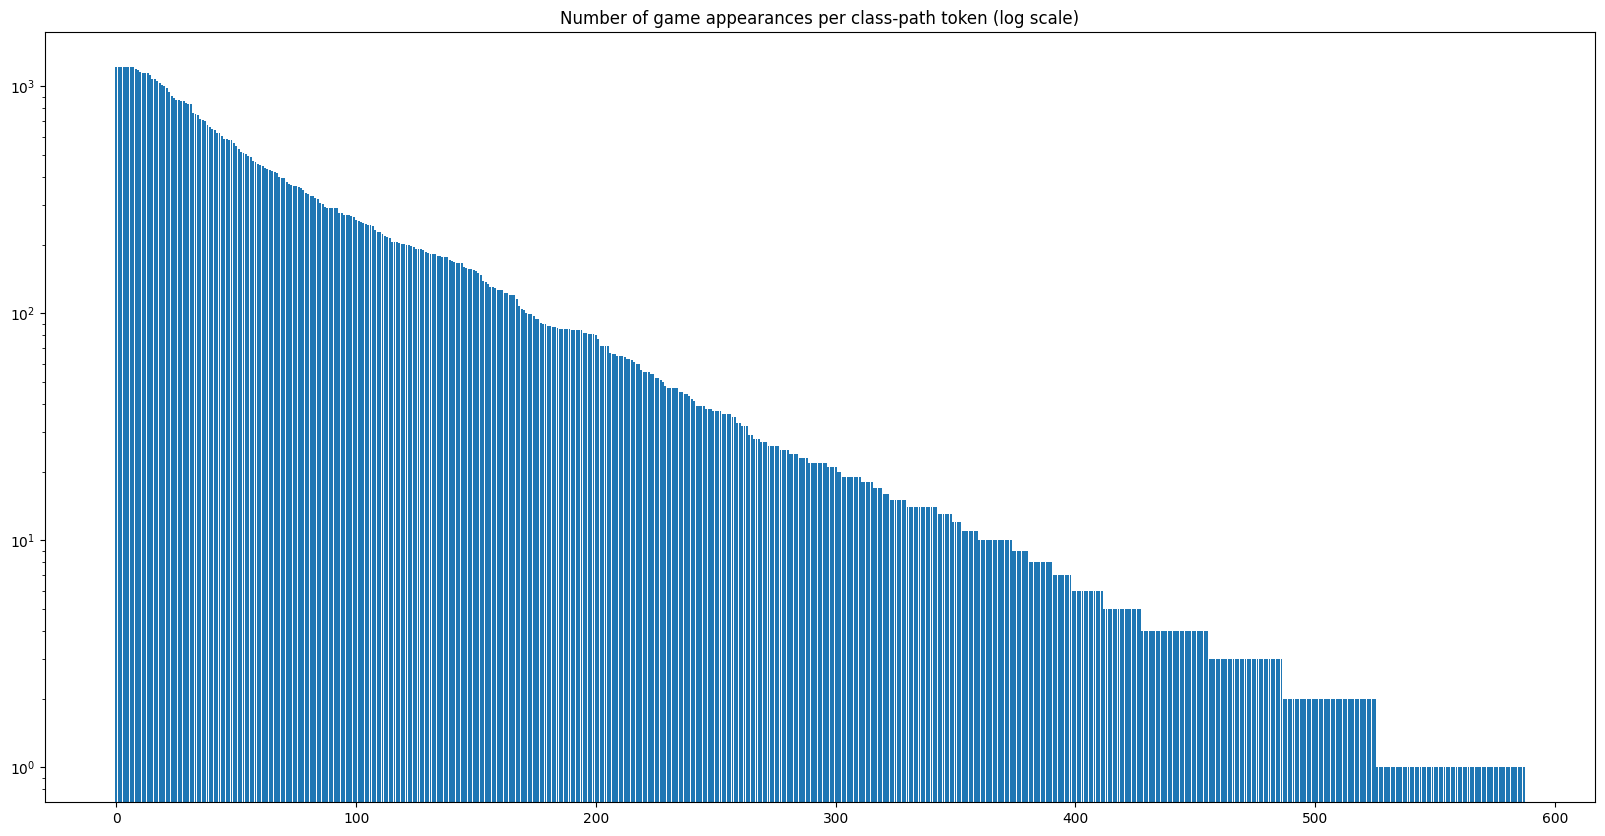

In [16]:
token_game_occurrences = Counter(sum([list(set(entry["class_paths"])) for entry in class_path_data], []))

fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(range(len(token_game_occurrences)), sorted(token_game_occurrences.values(), reverse=True))
ax.set_yscale('log')
plt.title("Number of game appearances per class-path token (log scale)")

In [61]:
num_occurrences_of_rarest_token = [min([token_game_occurrences[token] for token in set(entry["class_paths"])]) for entry in class_path_data]

thresholds = range(1, len(class_path_data)+1)
counts = []
for threshold in thresholds:
    counts.append(len([occurences for occurences in num_occurrences_of_rarest_token if occurences >= threshold]))

Text(0.5, 1.0, 'Number of games that can be written using only tokens that occur in at least N different games')

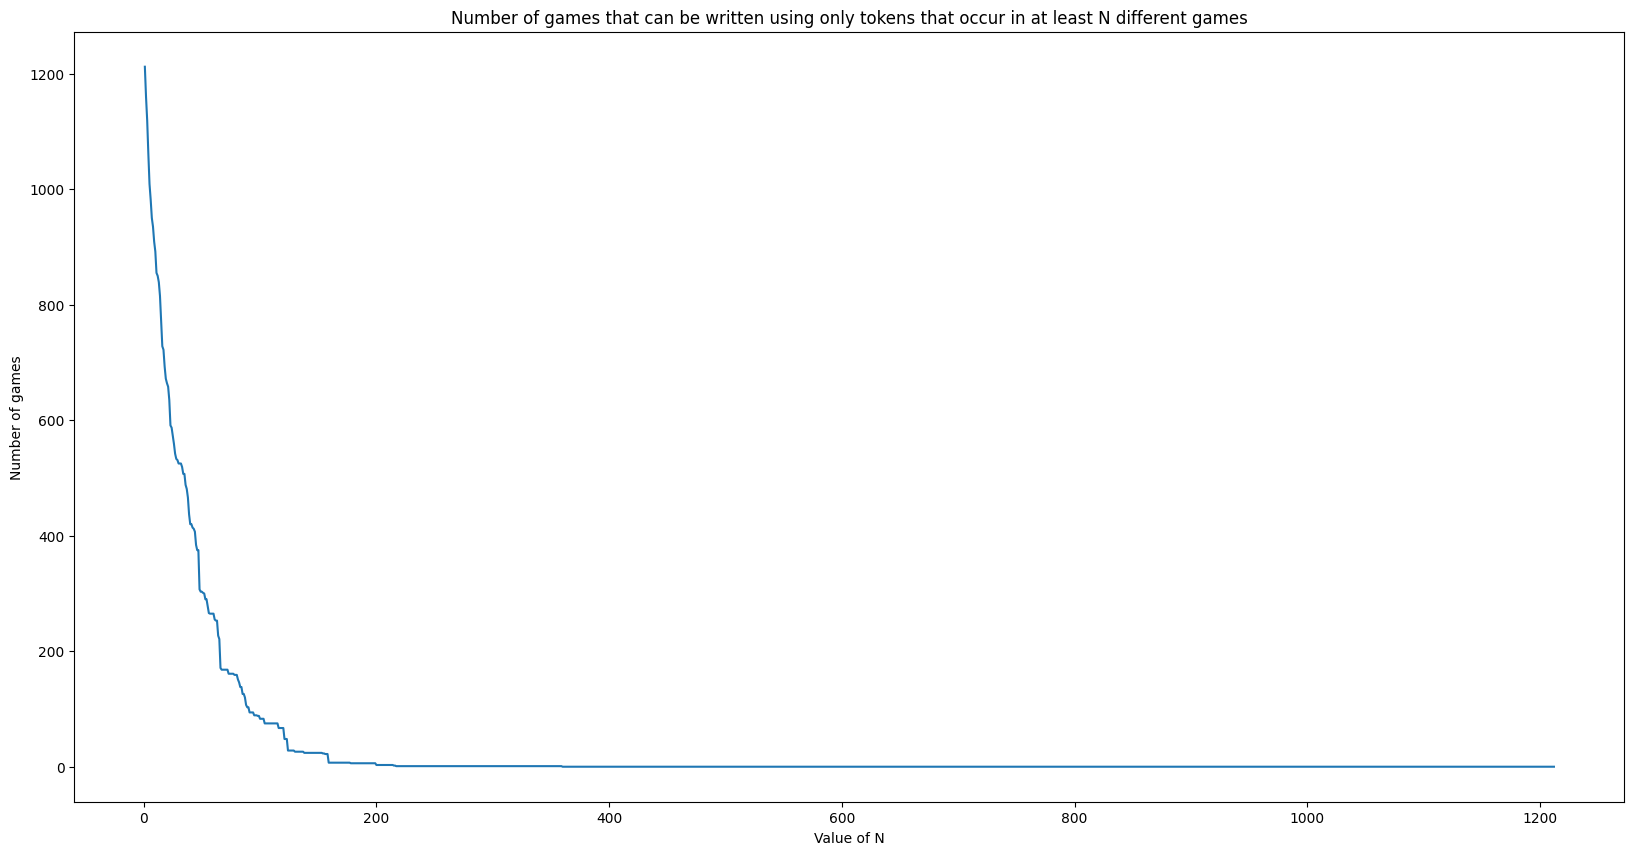

In [64]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(thresholds, counts)
ax.set_xlabel("Value of N")
ax.set_ylabel("Number of games")
ax.set_title("Number of games that can be written using only tokens that occur in at least N different games")

In [66]:
for i, count in enumerate(counts):
    if count >= i + 1:
        print(f"There exists a set of {i} games where every token appears in at least that many games!")

There exists a set of 0 games where every token appears in at least that many games!
There exists a set of 1 games where every token appears in at least that many games!
There exists a set of 2 games where every token appears in at least that many games!
There exists a set of 3 games where every token appears in at least that many games!
There exists a set of 4 games where every token appears in at least that many games!
There exists a set of 5 games where every token appears in at least that many games!
There exists a set of 6 games where every token appears in at least that many games!
There exists a set of 7 games where every token appears in at least that many games!
There exists a set of 8 games where every token appears in at least that many games!
There exists a set of 9 games where every token appears in at least that many games!
There exists a set of 10 games where every token appears in at least that many games!
There exists a set of 11 games where every token appears in at l

In [17]:
for entry in class_path_data:
    entry["unique_class_paths"] = set(entry["class_paths"])

In [22]:
# Greedy maximization: take the game with the smallest set of unique tokens, then add the next game which adds the
# smallest number of new tokens. Repeat until the set of tokens reaches some threshold

def get_greedy_game_set(threshold: int, verbose: bool = False):

    current_token_set = set()
    current_game_set = set()

    while len(current_token_set) < threshold:
        # Find the game with the smallest set of unique tokens
        games_by_new_tokens = list(sorted(class_path_data, key=lambda entry: len(entry["unique_class_paths"].difference(current_token_set))))

        best_game = None
        for game in games_by_new_tokens:
            if game["name"] not in current_game_set:
                best_game = game
                break
        
        if best_game is None:
            if verbose: print("No more games to add")
            break

        # Add the game to the current set
        current_game_set.add(best_game["name"])

        # Add the game's tokens to the current set
        current_token_set.update(best_game["unique_class_paths"])

        if verbose: print(f"Added game {best_game['name']} to set. Current token set size: {len(current_token_set)}")

    return current_game_set, current_token_set

In [23]:
for threshold in [100, 200, 300, 400, 500, 600]:
    print(f"With {threshold} tokens you can play at least {len(get_greedy_game_set(threshold)[0])} games")

With 100 tokens you can play 28 games
With 200 tokens you can play 113 games
With 300 tokens you can play 391 games
With 400 tokens you can play 552 games
With 500 tokens you can play 1010 games
With 600 tokens you can play 1212 games


In [42]:
# Beam-search implementation
def get_beam_search_game_set(threshold: int, num_beams: int):

    beams = [(set(), set()) for _ in range(num_beams)]

    done = False
    while not done:
        proposals = []

        for token_set, game_set in beams:
            games_by_new_tokens = list(sorted(class_path_data, key=lambda entry: len(entry["unique_class_paths"].difference(token_set))))

            new_proposals = []
            for game_data in games_by_new_tokens:
                if game_data["name"] not in game_set:
                    new_token_set = token_set | game_data["unique_class_paths"]
                    new_game_set = game_set | {game_data["name"]}

                    if len(new_token_set) <= threshold:
                        new_proposals.append((new_token_set, new_game_set))

                if len(new_proposals) >= num_beams:
                    break

            proposals += new_proposals

        if len(proposals) == 0:
            break

        # Sort by the number of tokens in the token set
        proposals = list(sorted(proposals, key=lambda proposal: len(proposal[0])))

        # Take the top `beams` proposals
        beams = proposals[:num_beams]

    return beams

In [65]:
for threshold in [100, 200, 300, 400, 500, 600]:
    print(f"With {threshold} tokens...")
    for num_beams in [1, 5, 10]:
        num_games = max([len(beam[1]) for beam in get_beam_search_game_set(threshold, num_beams)])
        print(f"\t...and {num_beams} beams, you can play at least {num_games} games")

With 100 tokens...
	...and 1 beams, you can play at least 27 games
	...and 5 beams, you can play at least 29 games
	...and 10 beams, you can play at least 29 games
With 200 tokens...
	...and 1 beams, you can play at least 114 games
	...and 5 beams, you can play at least 196 games
	...and 10 beams, you can play at least 202 games
With 300 tokens...
	...and 1 beams, you can play at least 393 games
	...and 5 beams, you can play at least 420 games
	...and 10 beams, you can play at least 417 games
With 400 tokens...
	...and 1 beams, you can play at least 552 games
	...and 5 beams, you can play at least 555 games
	...and 10 beams, you can play at least 617 games
With 500 tokens...
	...and 1 beams, you can play at least 1015 games


KeyboardInterrupt: 

In [75]:
# Iterative pruning: start with the full set of games and then remove every game that includes a token that appears in no more than N games
# Repeat until no games are removed

threshold = 5
current_game_set = class_path_data[:]

while True:
    token_game_occurrences = Counter(sum([list(set(entry["class_paths"])) for entry in current_game_set], []))
    num_occurrences_of_rarest_token = [min([token_game_occurrences[token] for token in set(entry["class_paths"])]) for entry in current_game_set]

    new_game_set = [game for game, occurrences in zip(current_game_set, num_occurrences_of_rarest_token) if occurrences > threshold]
    if len(new_game_set) == len(current_game_set):
        break

    print(f"...pruning to {len(new_game_set)} games")
    current_game_set = new_game_set

print(f"After iterative pruning with a threshold of {threshold}, we have {len(current_game_set)} games")

...pruning to 982 games
...pruning to 893 games
...pruning to 841 games
...pruning to 816 games
...pruning to 792 games
...pruning to 778 games
...pruning to 769 games
After iterative pruning with a threshold of 5, we have 769 games
